<a href="https://colab.research.google.com/github/thorchh/HandwrittenNumberRecognition/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

In [2]:
## Define the network
numEpochs = 3
batchSizeTrain = 64
batchSizeTest = 1000
learningRate = 0.01
momentum = 0.5
logInterval = 10

## Define the random seed
randomSeed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(randomSeed)

In [3]:
## Define the data loader
trainLoader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=True, download=True,
                                 transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081))
                                     ])),
    batch_size = batchSizeTrain, shuffle=True)

testLoader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=False, download=True,
                                    transform=torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize(
                                            (0.1307,), (0.3081))
                                        ])),
    batch_size = batchSizeTest, shuffle=True)

In [4]:
examples = enumerate(testLoader)
batchIdx, (exampleData, exampleTargets) = next(examples)

In [5]:
exampleData.shape

torch.Size([1000, 1, 28, 28])

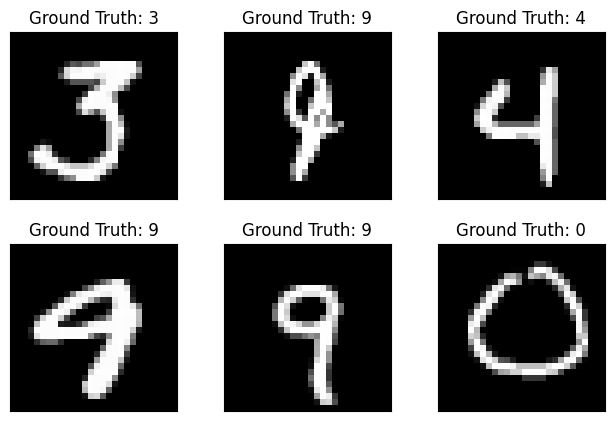

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(exampleTargets[i]))
    plt.xticks([])
    plt.yticks([])

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learningRate,
                      momentum=momentum)

In [10]:
trainLosses = []
trainCounter = []
testLosses = []
testCounter = [i*len(trainLoader.dataset) for i in range(numEpochs + 1)]

In [11]:
!mkdir results
import os

mkdir: cannot create directory ‘results’: File exists


In [12]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(trainLoader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % logInterval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(trainLoader.dataset),
        100. * batch_idx / len(trainLoader), loss.item()))
      trainLosses.append(loss.item())
      trainCounter.append(
        (batch_idx*64) + ((epoch-1)*len(trainLoader.dataset)))
      torch.save(network.state_dict(), '/results/model.pth')
      torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [13]:
def test():
  network.eval()
  testLoss = 0
  correct = 0
  with torch.no_grad():
    for data, target in testLoader:
      output = network(data)
      testLoss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  testLoss /= len(testLoader.dataset)
  testLosses.append(testLoss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  testLoss, correct, len(testLoader.dataset),
  100. * correct / len(testLoader.dataset)))

In [14]:
test()
for epoch in range(1, numEpochs + 1):
  train(epoch)
  test()

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140658
Train Epoch: 1 [12160/6

4 4


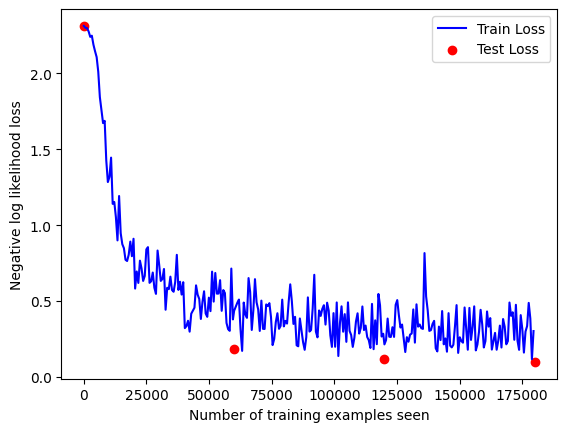

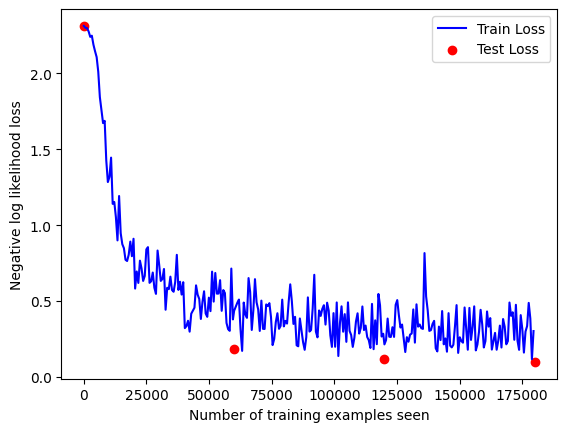

In [15]:
print(len(testCounter), len(testLosses))
fig = plt.figure()
plt.plot(trainCounter, trainLosses, color = 'blue')
plt.scatter(testCounter, testLosses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('Number of training examples seen')
plt.ylabel('Negative log likelihood loss')
fig

In [17]:
with torch.no_grad():
  output = network(exampleData)

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


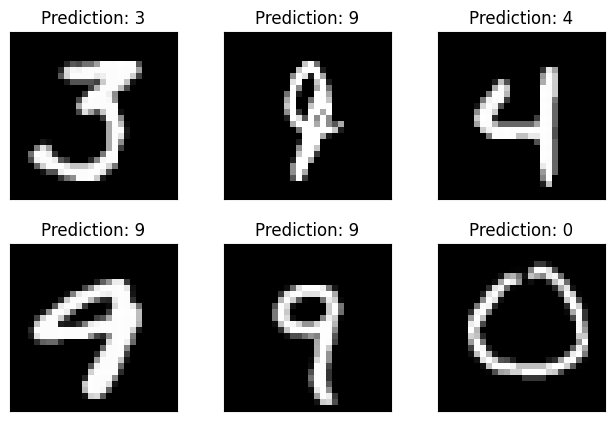

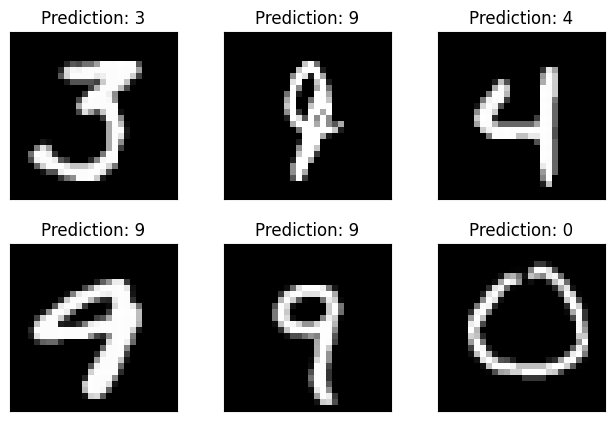

In [18]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig


In [19]:
continuedNetwork = Net()
continuedOptimiser = optim.SGD(network.parameters(), lr=learningRate,
                                momentum=momentum)

In [22]:
networkStateDict = torch.load('model.pth')
continuedNetwork.load_state_dict(networkStateDict)

optimizerStateDict = torch.load('optimizer.pth')
continuedOptimiser.load_state_dict(optimizerStateDict)

FileNotFoundError: ignored

In [ ]:
fig = plt.figure()
plt.plot(trainCounter, trainLosses, color='blue')
plt.scatter(trainCounter, testLosses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig